In [1]:
import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt
from pathlib import Path
import pprint
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from dataset import *
import random
from train import *
from sklearn.cross_decomposition import CCA
import itertools
from utils import *
from models import *

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [3]:
from allensdk.brain_observatory.static_gratings import StaticGratings, StimulusAnalysis


In [4]:
output_dir = '.'
boc =  BrainObservatoryCache(
    manifest_file=str(Path(output_dir) / 'brain_observatory_manifest.json'))
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


In [5]:
# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)
cre_lines_to_use = [
    'Cux2-CreERT2',
    'Emx1-IRES-Cre',
    'Fezf2-CreER',
    'Nr5a1-Cre',
    'Ntsr1-Cre_GN220',
    'Rbp4-Cre_KL100',
    'Rorb-IRES2-Cre',
    'Scnn1a-Tg3-Cre',
    'Slc17a7-IRES2-Cre',
    'Tlx3-Cre_PL56',
]

all cre lines:

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


Download Experiments for a Container

An experiment container is a group of experiments. Each experiment has a different stimulus protocol. For example, one experiment protocol contains the static gratings stimulus and another has the natural scenes stimulus. The BrainObservatoryCache helps you find out which experiment associated with a container has the stimuli you are interested in. First, let's see what experiments are available for a single container.

The session_type field indicates which experimental protocol was used. If you just want to find which experiment contains the static gratings stimulus, you can do the following:

In [5]:
# import allensdk.brain_observatory.stimulus_info as stim_info

# # pick one of the cux2 experiment containers
# cux2_ec_id = cux2_ecs[-1]['id']

# # Find the experiment with the static static gratings stimulus
# exp = boc.get_ophys_experiments(experiment_container_ids=[cux2_ec_id], 
#                                 stimuli=[stim_info.STATIC_GRATINGS])[0]
# print("Experiment with static gratings:")
# pprint.pprint(exp)

Now we can download the NWB file for this experiment.

In [6]:
exps = get_exps(boc, cre_lines=cre_lines_to_use, targeted_structures=['VISp'], session_types=['three_session_B'])
len(exps)
#exps = filter_exps(boc, exps, num_exps = 10, min_neuron = 50, max_neuron = 1000, behavior = False)

94

In [13]:

data_set = boc.get_ophys_experiment_data(exps[19]['id'])
cids = data_set.get_cell_specimen_ids()
len(cids)

331

In [12]:
set_seed(1)
group_labels = False
if group_labels:
    sequence = [0, 0, 0, 1, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 9, 2, 7, 8, 2, 10, 11, 5, 2, 6,
                12, 12, 13, 10, 4, 2, 13, 12, 0, 7, 14, 15, 14, 12, 13, 13, 13, 7, 11, 16, 6, 2, 2, 8, 10, 8,
                2, 2, 16, 17, 17, 17, 17, 17, 18, 18, 18, 19, 20, 17, 21, 18, 17, 18, 20, 22, 21, 17, 21, 20,
                17, 23, 17, 18, 21, 24, 24, 25, 25, 25, 21, 25, 17, 25, 23, 17, 17, 25, 17, 25, 26, 21, 8, 21,
                21, 27, 21, 17, 26, 8, 25, 22, 15, 28, 28, 29, 30, 20]
else:
    sequence = [i for i in range(118)] # no manual class combining
mapping_dict, num_classes = get_mapping_dict(sequence)

#TODO: Second item to experiment with, whether to use behavioral signals or not
behavior = False

#TODO: Third item to experiment with, how many ms before and after the image is shown should be used for model fitting
pre = 15
post = 7

#TODO: Fourth item to experiment with, dff means full neurons vs. pca the dimension-reduced version
#Play with different pca_comp values as well
data_type = 'pca'
pca_comp = 50

######## DO NOT CHANGE: GET ALL EXPERIMENTS #########
exps = get_exps(boc, cre_lines=cre_lines_to_use, targeted_structures=['VISp'], session_types=['three_session_B'])
#####################################################

# Optional: Filter experiments if needed
#exps = filter_exps(boc, exps, num_exps = 3, min_neuron = 100, max_neuron = 1000, behavior = False)

# Optional: Try CCA Matching
cca_ind = False

#TODO: Fifth item to experiment with, three options:
# 1) "single": to focus on performance on one randomly chosen experiment
# 2) "multi": to combine multiple experiments together then perform train/test split within itself 
# 3) "unseen": to split the 90+ experiments into a list of experiments for training vs. test
# then once we fit a model on the experiments in the training, we evaluate on 
# the unseen experiments in the test data. Will be used to test whether our model is generalizable
# to unseen population in the world or not
exp_type = 'multi'
num_exps = 10

######## DO NOT CHANGE THIS ########
exp_chosen = 22
####################################

#TODO: Sixth item to experiment with, train vs. test split ratio
train_prop = 0.9

#TODO: Seventh item to experiment with, pad the sequence or not
pad_ind = False

#TODO: Eighth item to experiment with, max_features
max_features = 400

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
if exp_type == 'single':
    exps = exps[exp_chosen:exp_chosen+1]
    dataset = prep_dataset(boc, exps, mapping_dict=mapping_dict, pre=pre, post=post, data_type=data_type, pca_comp=pca_comp, cca=cca_ind, behavior=behavior)
    #dataset = prep_dataset_by_static_grating(boc, exps, mapping_dict=mapping_dict, pre=pre, post=pre, behavior=False)
    train_dataset, test_dataset, train_orig_num_feat, test_orig_num_feat = get_train_test_split(dataset, train_prop = train_prop, pad = pad_ind, max_features=max_features)
elif exp_type == 'multi':
    exps = exps[exp_chosen:exp_chosen+num_exps]
    dataset = prep_dataset(boc, exps, mapping_dict=mapping_dict, pre=pre, post=post, data_type=data_type, pca_comp=pca_comp, cca=cca_ind, behavior=behavior)
    #dataset = prep_dataset_by_static_grating(boc, exps, mapping_dict=mapping_dict, pre=pre, post=pre, behavior=False)
    train_dataset, test_dataset, train_orig_num_feat, test_orig_num_feat = get_train_test_split(dataset, train_prop = train_prop, pad = pad_ind, max_features=max_features)
else:
    train_exps, test_exps = split_by_exps(exps, train_prop = train_prop)

exp#0 data explained variance: 0.69
exp#1 data explained variance: 0.33
exp#2 data explained variance: 0.79
exp#3 data explained variance: 0.29
exp#4 data explained variance: 0.63
exp#5 data explained variance: 0.37
exp#6 data explained variance: 0.75
exp#7 data explained variance: 0.41
exp#8 data explained variance: 0.46
exp#9 data explained variance: 0.28


In [13]:
train_losses, train_errors, train_top5_errors, val_losses, val_errors, val_top5_errors = [],[],[],[],[],[]

In [14]:
#exps = exps[exp_chosen:exp_chosen+1]
# dataset= prep_dataset(boc, exps, mapping_dict=mapping_dict, pre=pre, post=post, data_type=data_type, pca_comp=pca_comp, cca=cca_ind, behavior=behavior)
conditions = ['wo_CCA', 'w_CCA']
hidden_dim, embed_dim = 512, 512
num_layers = 2
dropout_prob = 0.7
model_type = 'GRU'
label_smoothing = 0.5
initial_lr = 0.001
warmup_epochs = 3
weight_decay = 1e-5
batch_size = 256
epochs = 100
clip = 1


train_dataset, test_dataset, train_orig_num_feat, test_orig_num_feat = get_train_test_split(dataset, train_prop = train_prop, pad = pad_ind, max_features=max_features)
if data_type == 'dff':
    input_dim = dataset['model_input'][0].shape[0]
elif data_type == 'pca':
    input_dim = pca_comp
else:
    input_dim = 120

model = RNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, embed_dim=embed_dim, num_layers=num_layers, num_classes=num_classes, dropout_prob=dropout_prob, nn_type = model_type)
# model = TransformerClassifier(input_dim=input_dim, hidden_dim=512, nlayers=1, nhead=8, num_classes=num_classes, dropout=0.5)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
scheduler = WarmupWithScheduledDropLR(optimizer, warmup_epochs=warmup_epochs, initial_lr=initial_lr, drop_epochs=[30, 70])
model, train_loss, train_error, train_top5_error, val_loss, val_error, val_top5_error = trainRNN(model, criterion, optimizer, scheduler, epochs, batch_size, clip, train_dataset, test_dataset, dry_run=False)
# model, train_loss, train_error, train_top5_error, val_loss, val_error, val_top5_error = trainTransformerClassifier(model, criterion, optimizer, scheduler, epochs, batch_size, train_dataset, test_dataset, dry_run=False)

train_losses.append(train_loss)
train_errors.append(train_error)
train_top5_errors.append(train_top5_error)
val_losses.append(val_loss)
val_errors.append(val_error)
val_top5_errors.append(val_top5_error)

Num parameters:  3239031
<class 'numpy.float64'>
Epoch 1/100
Training loss: 4.87, Training error: 98.24%, Training Top5 error: 92.62%
Validation loss: 4.66, Validation error: 96.71%, Validation Top5 error: 88.59%
<class 'numpy.float64'>
Epoch 2/100
Training loss: 4.76, Training error: 97.49%, Training Top5 error: 90.60%
Validation loss: 4.64, Validation error: 96.18%, Validation Top5 error: 88.07%
<class 'numpy.float64'>
Epoch 3/100
Training loss: 4.71, Training error: 97.04%, Training Top5 error: 89.52%
Validation loss: 4.63, Validation error: 96.00%, Validation Top5 error: 87.19%
<class 'numpy.float64'>
Epoch 4/100
Training loss: 4.67, Training error: 96.64%, Training Top5 error: 88.21%
Validation loss: 4.63, Validation error: 95.78%, Validation Top5 error: 87.34%
<class 'numpy.float64'>
Epoch 5/100
Training loss: 4.64, Training error: 96.21%, Training Top5 error: 87.44%
Validation loss: 4.63, Validation error: 95.88%, Validation Top5 error: 87.76%
<class 'numpy.float64'>
Epoch 6/100

KeyboardInterrupt: 

2

In [11]:
import json

def save_results(condition, **kwargs):
    # 'kwargs' is a dictionary that contains all the named arguments passed to the function

    # Add the condition to the results
    results = {'condition': condition}

    # Update the results dictionary with the additional arguments
    results.update(kwargs)

    # Define the filename using the condition
    filename = f'results_{condition}.json'

    # Write the dictionary to a JSON file
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)

    print(f'Results saved to {filename}')

In [16]:
for lst in val_top5_errors:
    print(np.mean(lst[-10:]))

0.9451822916666666


In [12]:


save_results('single_exp_RNN_scramble', models = conditions, train_losses=train_losses, train_errors=train_errors, train_top5_errors = train_top5_errors, 
             val_losses = val_losses, val_errors = val_errors, val_top5_errors = val_top5_errors)

Results saved to results_single_exp_RNN_scramble.json


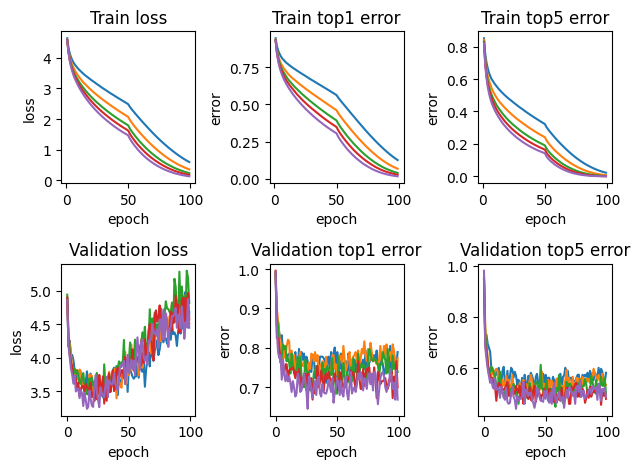

In [9]:
fig, axes = plt.subplots(2,3)
for i in range(len(train_losses)):
    axes[0,0].plot(train_losses[i])
    axes[0,0].set(xlabel = 'epoch', ylabel = 'loss', title='Train loss')
    axes[0,1].plot(train_errors[i])
    axes[0,1].set(xlabel = 'epoch', ylabel = 'error', title='Train top1 error')
    axes[0,2].plot(train_top5_errors[i])
    axes[0,2].set(xlabel = 'epoch', ylabel = 'error', title='Train top5 error')
    axes[1,0].plot(val_losses[i])
    axes[1,0].set_title('Validation loss')
    axes[1,0].set(xlabel = 'epoch', ylabel = 'loss', title='Validation loss')
    axes[1,1].plot(val_errors[i])
    axes[1,1].set(xlabel = 'epoch', ylabel = 'error', title='Validation top1 error')
    axes[1,2].plot(val_top5_errors[i])
    axes[1,2].set(xlabel = 'epoch', ylabel = 'error', title='Validation top5 error')

fig.tight_layout()

In [28]:
stim_df = get_stim_df(boc, exps[22], stimulus_name='static_gratings')
stim_df

,orientation,spatial_frequency,phase,start,end
0,150.0,0.02,0.50,744,751
1,30.0,0.32,0.50,752,759
2,0.0,0.02,0.25,759,766
3,90.0,0.16,0.75,767,774
4,60.0,0.02,0.25,774,781
...,...,...,...,...,...
5995,150.0,0.16,0.75,113584,113591
5996,60.0,0.02,0.50,113592,113599
5997,150.0,0.32,0.00,113599,113606
5998,120.0,0.32,0.00,113607,113614


In [68]:
def index_by_combinations(df):
    # Initialize the dictionary with all possible combinations
    max_ori_sg = 5
    max_sf_sg = 4
    max_phase_sg = 3
    combinations = itertools.product(range(0, max_ori_sg + 1), range(1, max_sf_sg + 2), range(0, max_phase_sg + 1))
    indexes_dict = {combination: [] for combination in combinations}
    print(indexes_dict)
    # Iterate through each row
    for index, row in df.iterrows():
        # Check if osi_sg is within the specified range
        if 0.5 < row['osi_sg'] <= 1.5:
            # Create a tuple of the combination
            combination = (row['ori_sg'], row['sf_sg'], row['phase_sg'])

            # Append the index to the corresponding list
            indexes_dict.get(combination, []).append(index)

    return indexes_dict

def average_rows_by_index_dict(X, index_dict):
    # Initialize an output array with the same number of columns as X and rows equal to the length of index_dict
    output_array = np.zeros((len(index_dict), X.shape[1]))

    for i, (key, indexes) in enumerate(index_dict.items()):
        if indexes:  # Check if the list of indexes is not empty
            selected_rows = X[indexes]
            output_array[i] = np.mean(selected_rows, axis=0)
        # If the list of indexes is empty, the row remains zeros as initialized

    return output_array

In [63]:
sg = StaticGratings(data_set)
sg_peak = sg.peak

5
0
5
1
3
0


In [69]:
indexes_dict = index_by_combinations(sg_peak)
dff = get_fluo(boc, exps[19])
dff.shape
output = average_rows_by_index_dict(dff, indexes_dict)
output.shape

{(0, 1, 0): [], (0, 1, 1): [], (0, 1, 2): [], (0, 1, 3): [], (0, 2, 0): [], (0, 2, 1): [], (0, 2, 2): [], (0, 2, 3): [], (0, 3, 0): [], (0, 3, 1): [], (0, 3, 2): [], (0, 3, 3): [], (0, 4, 0): [], (0, 4, 1): [], (0, 4, 2): [], (0, 4, 3): [], (0, 5, 0): [], (0, 5, 1): [], (0, 5, 2): [], (0, 5, 3): [], (1, 1, 0): [], (1, 1, 1): [], (1, 1, 2): [], (1, 1, 3): [], (1, 2, 0): [], (1, 2, 1): [], (1, 2, 2): [], (1, 2, 3): [], (1, 3, 0): [], (1, 3, 1): [], (1, 3, 2): [], (1, 3, 3): [], (1, 4, 0): [], (1, 4, 1): [], (1, 4, 2): [], (1, 4, 3): [], (1, 5, 0): [], (1, 5, 1): [], (1, 5, 2): [], (1, 5, 3): [], (2, 1, 0): [], (2, 1, 1): [], (2, 1, 2): [], (2, 1, 3): [], (2, 2, 0): [], (2, 2, 1): [], (2, 2, 2): [], (2, 2, 3): [], (2, 3, 0): [], (2, 3, 1): [], (2, 3, 2): [], (2, 3, 3): [], (2, 4, 0): [], (2, 4, 1): [], (2, 4, 2): [], (2, 4, 3): [], (2, 5, 0): [], (2, 5, 1): [], (2, 5, 2): [], (2, 5, 3): [], (3, 1, 0): [], (3, 1, 1): [], (3, 1, 2): [], (3, 1, 3): [], (3, 2, 0): [], (3, 2, 1): [], (3, 2, 2)

(120, 113869)

<AxesSubplot:xlabel='timesteps', ylabel='sg'>

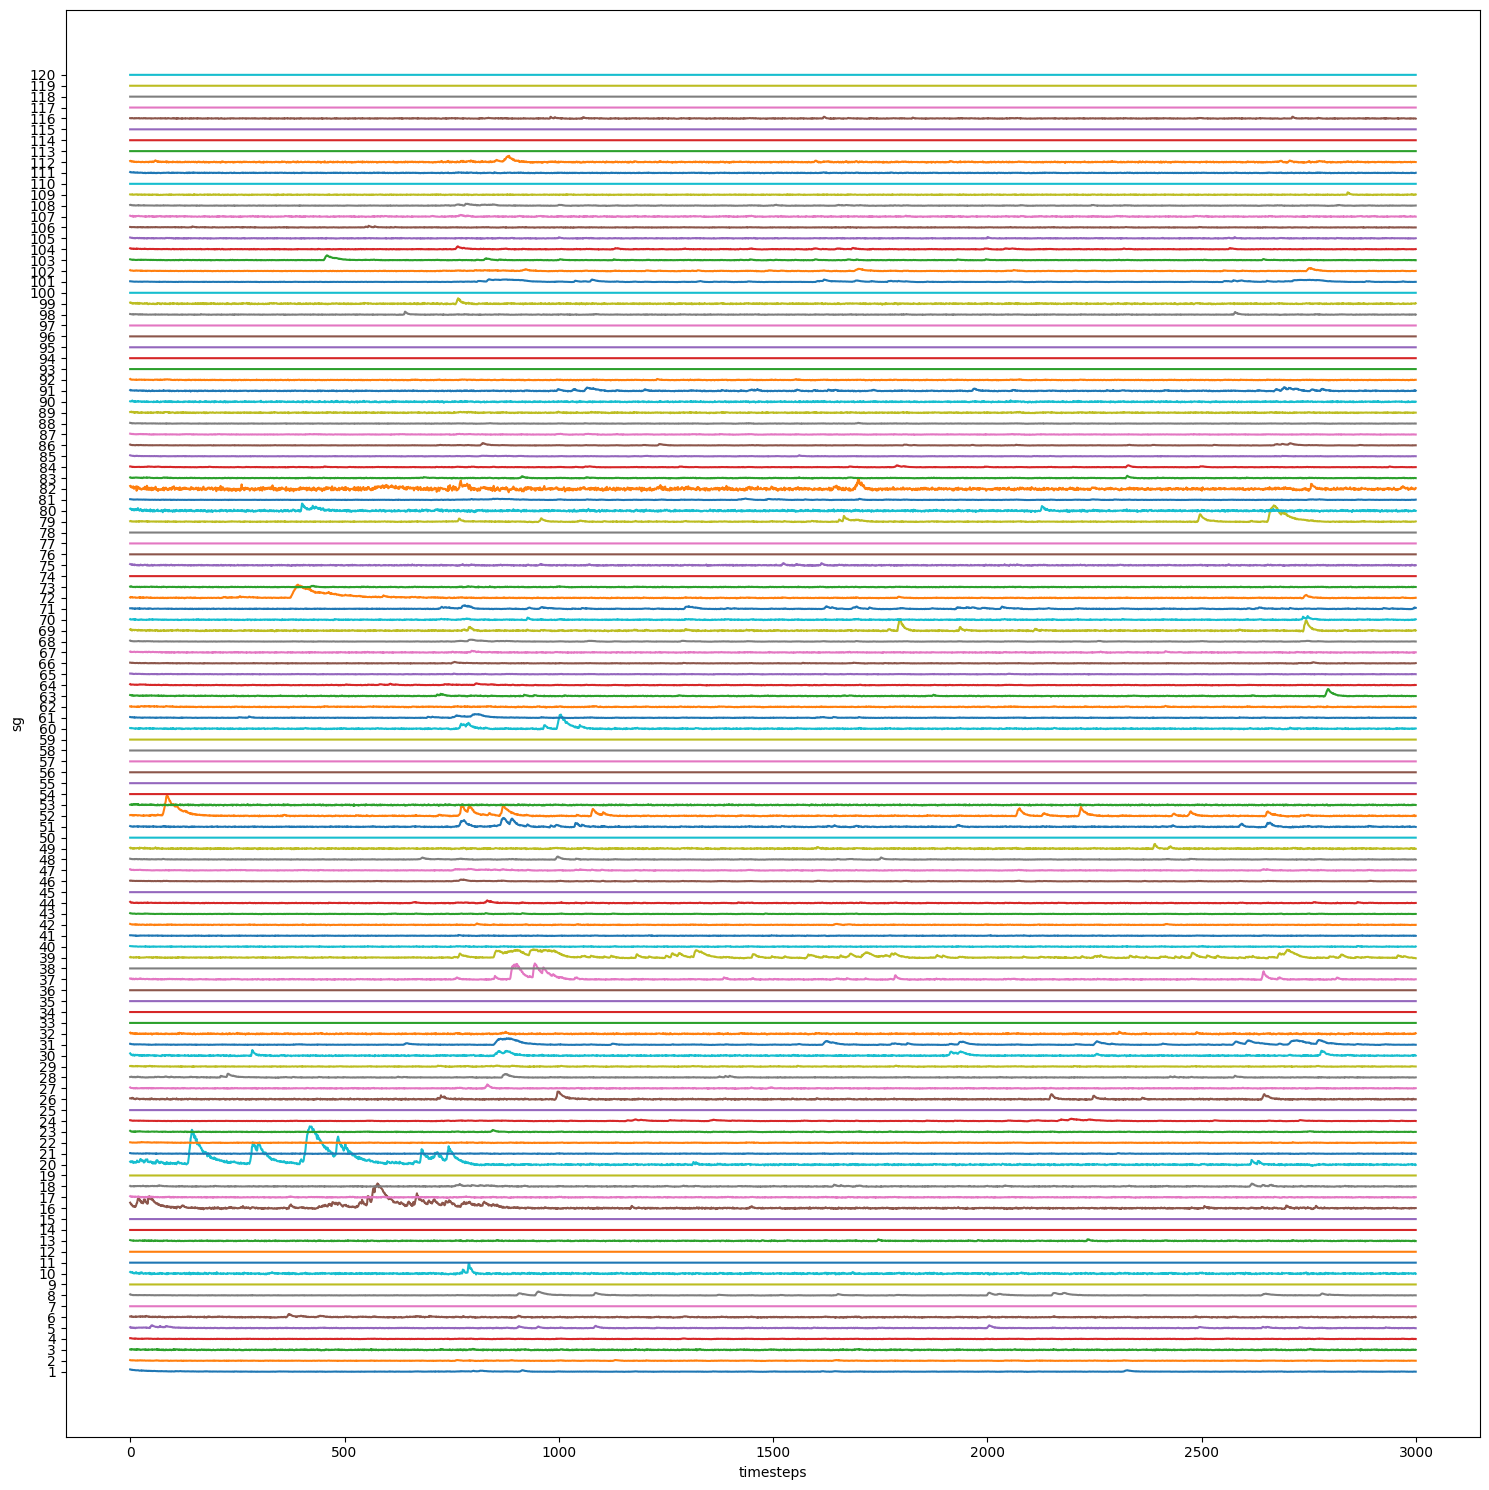

In [71]:
plot_traces(output, range(3000), input_type='sg')

In [65]:
sg_peak

,ori_sg,sf_sg,phase_sg,reliability_sg,osi_sg,peak_dff_sg,ptest_sg,time_to_peak_sg,cell_specimen_id,p_run_sg,cv_os_sg,run_modulation_sg,sf_index_sg
0,0,2,1,0.121548,0.735451,5.992749,0.0,0.29925,589170135,NaN,0.637282,NaN,0.320538
1,0,2,3,0.085087,0.31581,2.940015,0.0,0.36575,517422901,0.540038,0.208668,0.297883,0.325737
2,0,1,3,0.037627,0.864933,1.35171,0.00023,0.36575,517427558,NaN,0.795348,NaN,0.270415
3,4,2,1,0.00541,0.566688,1.169121,0.0,0.399,517425384,NaN,0.42286,NaN,0.268128
4,0,2,3,0.00993,0.191633,1.579819,0.0,0.43225,517425029,0.023964,0.143963,0.694019,0.243677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,1,3,2,0.00398,1.088575,2.195513,0.0,0.29925,517425038,0.295579,0.575782,-0.909954,0.19518
327,4,1,3,0.010657,1.036754,2.319835,0.000025,0.3325,517424117,0.46065,0.815602,0.732535,0.24499
328,4,2,0,0.010296,0.711135,0.823419,0.000041,0.23275,517425048,0.860521,0.479625,-0.401504,0.278311
329,5,1,3,0.034132,1.221089,3.188973,0.0,0.3325,517428075,0.22394,0.501809,0.471121,0.357247


(331, 113869)

In [41]:
osi_cells = (sg_peak.osi_sg > 0.5) & (sg_peak.osi_sg <= 1.5)
osi_cells

0      True
1      True
2      True
3     False
4      True
      ...  
82     True
83    False
84     True
85    False
86     True
Name: osi_sg, Length: 87, dtype: bool

In [6]:
pre = 15
post = 7
dataset = prep_dataset(boc, exps[22:23], pre, post, data_type='dff')

In [ ]:
data2plot = 100000
ax = plot_traces(dataset['model_input'][data2plot].numpy(), np.arange(45), input_type='pca', figsize=(2,10))
ax.set_title(f"image#{dataset['model_labels'][data2plot].numpy()}")
ax.axvline(x = 30, color = 'r', linestyle = '--')

test code for training